# Final model training script:
Please run Combine_data_with_gold_price.ipynb to get the final processed and annotated data file.
'Final\adithya\Data\combined_dataset_with_price_change.csv'
before running this script.

### Import necessary libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader, random_split
import numpy as np
import torch
import torch.nn as nn
from tqdm import notebook as tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import shutil
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


In [2]:
#Import our defined classes and functions
from modules import NewsDataset, SetTransformer , VariableSetDataset
from functions import group_into_variable_sets, load_checkpoint

### Read the dataset.

In [ ]:
# df = pd.read_csv("../Data/combined_dataset_with_price_change.csv",index_col=0)

# Load
df = pd.read_pickle('../Data/combined_dataset_with_price_change.pkl')
print("Number of rows in df:",df.shape)
df.head()

### Initialize the dataloader and model

In [ ]:
#Some settings
batch_size = 50
articles_per_day = 10

In [ ]:
#Group input data into sets for use in model.
encodings, price_changes, masks = group_into_variable_sets(df)


In [ ]:
print(encodings.shape,price_changes.shape,masks.shape)

In [ ]:
dataset = VariableSetDataset(encodings, price_changes, masks)

# Calculate split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = SetTransformer(
    dim_input = 512, 
    num_outputs = 1, #One final prediction
    dim_output = 1, #1D output for price change
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=True #Layer normalization
    )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
#Comment this cell if you don't have the package installed
from torchsummary import summary
print(summary(model,(1, 10, 512)))

In [ ]:
#Remove old runs data.
if os.path.exists('runs') and os.path.isdir('runs'):
    for item in os.listdir('runs'):
        item_path = os.path.join('runs', item)
        if os.path.isfile(item_path):
            os.remove(item_path)  # Remove file
        else:
            shutil.rmtree(item_path)  # Remove subdirectory

In [ ]:
# Initialize TensorBoard writer
writer = SummaryWriter()

In [ ]:
# After running this cell, visit http://localhost:6006 on your browser to visualize the training process.
%load_ext tensorboard 
# %reload_ext tensorboard

In [ ]:
#Run this in your terminal separately to visualize the training process live
%tensorboard --logdir=runs --reload_interval=30 --host=127.0.0.1 #Autoreload every 30s

In [ ]:
plt.ioff()  # Turn off interactive mode initially
train_losses = []
val_losses = []
epochs_list = []
val_epochs_list = []

# Training loop
num_epochs = 10
pbar = tqdm.tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

avg_loss = 0.0
avg_val_loss = 0.0

for epoch in pbar:
    model.train()
    losses = []
    
    for batch_idx, (inps, outs, masks) in enumerate(train_loader):
        inps = inps.to(device)
        outs = outs.to(device)
        masks = masks.to(device)
        
        preds = model(inps,mask= masks)
        if preds.dim() > 1:
            preds = preds.squeeze()
        if outs.dim() > 1:
            outs = outs.squeeze()
        
        loss = criterion(preds, outs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = np.mean(losses)
    train_losses.append(avg_loss)
    epochs_list.append(epoch)
    
    writer.add_scalar('Loss/train', avg_loss, epoch)
    
    # Validation every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        val_losses_temp = []
        
        with torch.no_grad():
            for inps, outs, masks in test_loader:
                inps = inps.to(device)
                outs = outs.to(device)
                masks = masks.to(device)

                
                preds = model(inps,mask = masks)
                if preds.dim() > 1:
                    preds = preds.squeeze()
                if outs.dim() > 1:
                    outs = outs.squeeze()
                
                loss = criterion(preds, outs)
                val_losses_temp.append(loss.item())
        
        avg_val_loss = np.mean(val_losses_temp)
        val_losses.append(avg_val_loss)
        val_epochs_list.append(epoch)
        
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    
    # Update plot every 10 epochs
    if epoch % 1 == 0:
        clear_output(wait=True)
        
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', alpha=0.8, linewidth=2)
        if val_losses:
            plt.plot(val_epochs_list, val_losses, 'r-', label='Validation Loss', 
                    alpha=0.8, marker='o', linewidth=2, markersize=6)
        
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training and Validation Loss (Live Update)', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'val_loss': f'{avg_val_loss:.4f}'})

In [ ]:
# Save the model checkpoint
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss,
    'val_loss': avg_val_loss
}
torch.save(final_checkpoint, 'FinalModel/final_model.pth')

## Load and use model [Run library import then continue from here]

In [3]:
model = SetTransformer(
    dim_input = 512, 
    num_outputs = 1, #One final prediction
    dim_output = 1, #1D output for price change
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=True #Layer normalization
    )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [4]:
# Load the model from the checkpoint
checkpoint_path = 'FinalModel/final_model.pth'
if os.path.exists(checkpoint_path):
    start_epoch, start_loss ,model, optimizer = load_checkpoint(checkpoint_path, model, optimizer,device)
    print(f"Model loaded from {checkpoint_path} at epoch {start_epoch} with loss {start_loss:.4f}")
else:
    start_epoch, start_loss = 0, float('inf')
    print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")

Model loaded from FinalModel/final_model.pth at epoch 10 with loss 0.4513


#### Test call example

In [5]:
model.eval()

SetTransformer(
  (enc1): ISAB(
    (mab0): MAB(
      (fc_q): Linear(in_features=128, out_features=128, bias=True)
      (fc_k): Linear(in_features=512, out_features=128, bias=True)
      (fc_v): Linear(in_features=512, out_features=128, bias=True)
      (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc_o): Linear(in_features=128, out_features=128, bias=True)
    )
    (mab1): MAB(
      (fc_q): Linear(in_features=512, out_features=128, bias=True)
      (fc_k): Linear(in_features=128, out_features=128, bias=True)
      (fc_v): Linear(in_features=128, out_features=128, bias=True)
      (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc_o): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (enc2): ISAB(
    (mab0): MAB(
      (fc_q): Linear(in_features=128, out_features=128, bias=True)
      (fc_k): 

In [6]:
#Say 10 articles were present for today
inputs = np.random.rand(1, 10, 512).astype(np.float32)
masks = np.ones((1,10)).astype(np.float32)


inputs = torch.tensor(inputs, dtype=torch.float32).to(device=device)
masks = torch.tensor(masks, dtype=torch.float32).to(device=device)

print(inputs.shape, masks.shape)
preds = model(inputs,mask= masks)

print("The predicted price is: ",preds)

torch.Size([1, 10, 512]) torch.Size([1, 10])
The predicted price is:  tensor([[[-0.0255]]], device='cuda:0', grad_fn=<ViewBackward0>)


### Evaluate model

In [14]:
import sys 

parent_dir = os.path.abspath(os.path.join('./','..'))
sys.path.insert(0, parent_dir)

from Tarun.modules.functions import predict_sentiment, preprocess_dataset, generate_topic_encodings,get_sentiment_combined_encodings,group_into_variable_sets

c:\Users\adith\anaconda3\envs\MLEnvt_Python38\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [15]:
#Load evaluation data text
df = pd.read_csv("../../deepak/combined_eval.csv",index_col=0)
df

,Date,Content,Label
0,2023-10-03,the silver investor index held above 50.0 mark...,2
1,2023-10-03,while gold has retreated from the record highs...,2
2,2023-10-03,gold bullion finds fewest buyers in 4 years ar...,2
3,2023-10-07,not to question. the thing we call wall street...,2
4,2023-10-07,"treasuries, gold and guy debord article:the so...",2
...,...,...,...
4080,2025-06-13,microsoft hits an all-time high. here's why th...,0
4081,2025-06-13,"earnings evolution microsoft, meta, and nvidia...",0
4082,2025-06-13,"story continues in nvidia's latest quarter, wh...",0
4083,2025-06-13,"walmart has a sky-high p/e ratio of 41.6, and ...",0


In [16]:
#Get encodings
df.rename(columns={'Content':'text'},inplace=True)
df_with_encodings = generate_topic_encodings(df)
df_with_encodings

KeyboardInterrupt: 

In [ ]:
df_with_encodings.isna().sum()

In [ ]:
#Get sentiments
from transformers import AutoModelForSequenceClassification, AutoTokenizer

path = "../../Tarun/Model/finbert_best_model_merged"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)

In [ ]:
#Process 10 at a time since it is too large.
model.eval()
model = model.to(device)
text = list()

out = []
set = 1
text_list = list(df_with_encodings.text)

for i in tqdm.tqdm(range(0,len(text_list),set)):

    inp = text_list[i : i + set]

    # Tokenize input
    inputs = tokenizer(
        inp,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=1)[0].item()

    # Map prediction to sentiment
    sentiment_map = {0: "positive", 1: "neutral", 2: "negative"}
    confidence = probs[0][predicted_class].item()

    out.append( {
        "text": inp,
        "sentiment": sentiment_map[predicted_class],
        "confidence": f"{confidence:.4f}",
        "logits": logits[0].cpu().numpy().tolist(),
        "probabilities": {
            "positive": f"{probs[0][0].item():.4f}",
            "neutral": f"{probs[0][1].item():.4f}",
            "negative": f"{probs[0][2].item():.4f}"
        }
    })

In [ ]:
df_with_sentiment = pd.DataFrame.from_dict(out)
df_with_sentiment

In [ ]:
df_with_sentiment_and_encodings = pd.concat([df_with_sentiment, df_with_encodings.drop(columns='text')],axis = 1)
df_with_sentiment_and_encodings

In [ ]:
#Create a copy before processing
df_processed = df_with_sentiment_and_encodings.copy()

#Parse prediction text into a dictionary
df_processed['probabilities'] = df_processed['probabilities'].apply(lambda x: eval(x) if isinstance(x, str) else x)

#Extract net sentiment score [Between -1 and 1]
df_processed['sentiment'] = df_processed['probabilities'].apply(lambda x: float(x['positive']) - float(x['negative']))
df_processed['confidence'] = df_processed['confidence'].astype(float)
df_processed['sentiment'] = df_processed['sentiment'] * df_processed['confidence']

df_out = df_processed[['Date','text','sentiment','topic_encodings','Label']].copy()
df_out = df_processed.copy()

df_out

In [17]:
df_gold = pd.read_csv('../../Jaison/Archive/Model_Evaluation_Code/Data/GOLDBEES_ETF_price_data.csv')
df_gold.head()

,Date,Open,High,Low,Close,Volume
0,2010-02-05,15.980000,16.011000,15.7385,15.765000,2836000
1,2010-02-08,16.031000,16.098000,15.9600,16.062500,445700
2,2010-02-09,16.065001,16.065001,15.9600,15.997200,669100
3,2010-02-10,16.090000,16.108999,16.0221,16.060900,335400
4,2010-02-11,16.099001,16.099001,16.0305,16.059299,385300


In [ ]:
def add_gold_price_change(df_data,df_gold):
    

    #Merge above dataframe with our gold data.

    df_gold_premerge = df_gold.copy()
    df_data_premerge = df_data.copy()

    df_gold_premerge['Date'] = pd.to_datetime(df_gold_premerge['Date'])
    df_data_premerge['Date'] = pd.to_datetime(df_data_premerge['date'])

    # Compute the relative change in price from one day to the next before merging.
    df_gold_premerge = df_gold_premerge.sort_values(by='Date').reset_index(drop=True)
    df_gold_premerge['next_day_price'] = df_gold_premerge['Close'].shift(-1)
    df_gold_premerge['next_day'] = df_gold_premerge['Date'].shift(-1)
    df_gold_premerge['day_gap'] = (df_gold_premerge['next_day'] - df_gold_premerge['Date']).dt.days
    df_gold_premerge['relative_change'] = (df_gold_premerge['next_day_price'] - df_gold_premerge['Close']) / df_gold_premerge['day_gap']

    #Make it a percentage change
    df_gold_premerge['relative_change'] = 100 * (df_gold_premerge['relative_change'] / df_gold_premerge['Close'])

    # # We want to predict gold price for the next day. Data to use for prediction is the day before. ]
    df_gold_premerge['Date'] = df_gold_premerge['Date'] - pd.Timedelta(days=1)

    # Perform the merge on the adjusted date
    merged_df = pd.merge(df_data_premerge, df_gold_premerge, on='Date', how='inner')
    merged_df['sentiment_combined_encodings'] =  merged_df['topic_encodings'] * merged_df['sentiment']

    #Rename relative_change column to price_percentage_change
    merged_df = merged_df.rename(columns={'relative_change':'price_percentage_change'})
    final_df = merged_df[['Date','text','sentiment','topic_encodings','sentiment_combined_encodings','price_percentage_change','Close','next_day_price']].copy()

    return final_df

#Merge data with Gold data
final_df = add_gold_price_change(df_out.rename(columns={'Date':'date'}),df_gold)
final_df.head()

In [ ]:
df_temp = final_df.rename(columns={'topic_encodings':'topic_encodings','sentiment':'sentiment','Date':'date'}).copy()
final_df['sentiment_combined_encodings'] = get_sentiment_combined_encodings(df_temp)['sentiment_combined_encodings']
final_df

In [ ]:
final_df['Label'] = df_out['Label']

In [ ]:
final_df.columns

In [ ]:
final_df_clean = final_df[['Date','sentiment_combined_encodings','price_percentage_change','Label','Close','next_day_price']]
final_df_clean

In [ ]:
final_df_clean.to_pickle("Pre_prediction_validation_data.pkl")

In [ ]:
# final_df_clean = pd.("Pre_prediction_validation_data.pkl")

AttributeError: module 'pandas' has no attribute 'from_pickle'

In [ ]:
def group_into_variable_sets(df, max_articles_per_day=None):
    """
    Group data into variable-sized sets with padding and masking
    """
    # Group by date and get actual lists
    group_dict = df.groupby('Date')
    grouped = group_dict['sentiment_combined_encodings'].apply(list)
    price_changes = group_dict.first()['price_percentage_change'].values
    dates = [name for name,unused_df in group_dict]
    
    # Find max set size if not provided
    if max_articles_per_day is None:
        max_articles_per_day = max(len(articles) for articles in grouped)
        print(f"Max articles per day: {max_articles_per_day}")
    
    # Pad sequences and create masks
    padded_encodings = []
    masks = []
    
    for articles in grouped:
        current_length = len(articles)
        
        # Pad with zeros if needed
        if current_length < max_articles_per_day:
            # Assuming articles are numpy arrays or lists of same dimension
            encoding_dim = len(articles[0]) if current_length > 0 else 768  # Default embedding dim
            padded = articles + [np.zeros(encoding_dim)] * (max_articles_per_day - current_length)
        else:
            padded = articles[:max_articles_per_day]  # Truncate if too long
            current_length = max_articles_per_day
        
        padded_encodings.append(padded)
        
        # Create mask: 1 for real data, 0 for padding
        mask = [1] * min(current_length, max_articles_per_day) + [0] * max(0, max_articles_per_day - current_length)
        masks.append(mask)
    
    encodings = np.array(padded_encodings, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)
    price_changes = np.array(price_changes, dtype=np.float32).reshape(-1, 1)
    
    return encodings, price_changes, masks, dates

encodings, price_changes, masks ,dates= group_into_variable_sets(final_df_clean)

In [ ]:
model = SetTransformer(
    dim_input = 512, 
    num_outputs = 1, #One final prediction
    dim_output = 1, #1D output for price change
    num_inds=32, 
    dim_hidden=128, 
    num_heads=4, 
    ln=True #Layer normalization
    )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Load the model from the checkpoint
checkpoint_path = 'FinalModel/final_model.pth'
if os.path.exists(checkpoint_path):
    start_epoch, start_loss ,model, optimizer = load_checkpoint(checkpoint_path, model, optimizer,device)
    print(f"Model loaded from {checkpoint_path} at epoch {start_epoch} with loss {start_loss:.4f}")
else:
    start_epoch, start_loss = 0, float('inf')
    print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")

In [ ]:
encodings_t.shape,masks_t.shape

In [ ]:
encodings_t = torch.tensor(encodings, dtype=torch.float32).to(device=device)
masks_t = torch.tensor(masks, dtype=torch.float32).to(device=device)


with torch.no_grad():
    inps = encodings_t.to(device)
    m = masks_t.to(device)
    
    preds = model(inps,mask = m)
    if preds.dim() > 1:
        preds = preds.squeeze()


In [ ]:
df_preds = pd.DataFrame({'Date': dates, 'Predictions': preds.cpu()})
df_preds

In [ ]:
final_df_clean['Predictions'] = final_df_clean['Date'].map(df_preds.set_index('Date')['Predictions'])
final_df_clean

In [ ]:
final_df_clean['predicted_price'] = final_df_clean['Close']  * (1 + final_df_clean['Predictions']/100)
final_df_clean

In [ ]:
final_df_clean.columns

In [ ]:
df = final_df_clean[['Date','next_day_price','predicted_price','Predictions','price_percentage_change', 'Label']]

df = df.rename(columns = {'next_day_price':'Actual Price','predicted_price':'Predicted Price','Predictions':'Predicted Change','price_percentage_change':'Actual Change', 'Label':'Ground truth Label'})
df

In [ ]:
df.to_csv('final_predictions.csv')

In [23]:
df = pd.read_csv('final_predictions.csv')

In [ ]:
# df_dump = df.copy()
# df_dump['Date'] = df['Date'].dt.date #.apply(lambda t: t.strftime("%d-%m-%Y"))
# df_dump = df_dump[['Date','Actual Price','Predicted Price']].groupby('Date').first()
# df_dump.to_csv('final_predictions_cols.csv')
# df_dump

AttributeError: Can only use .dt accessor with datetimelike values

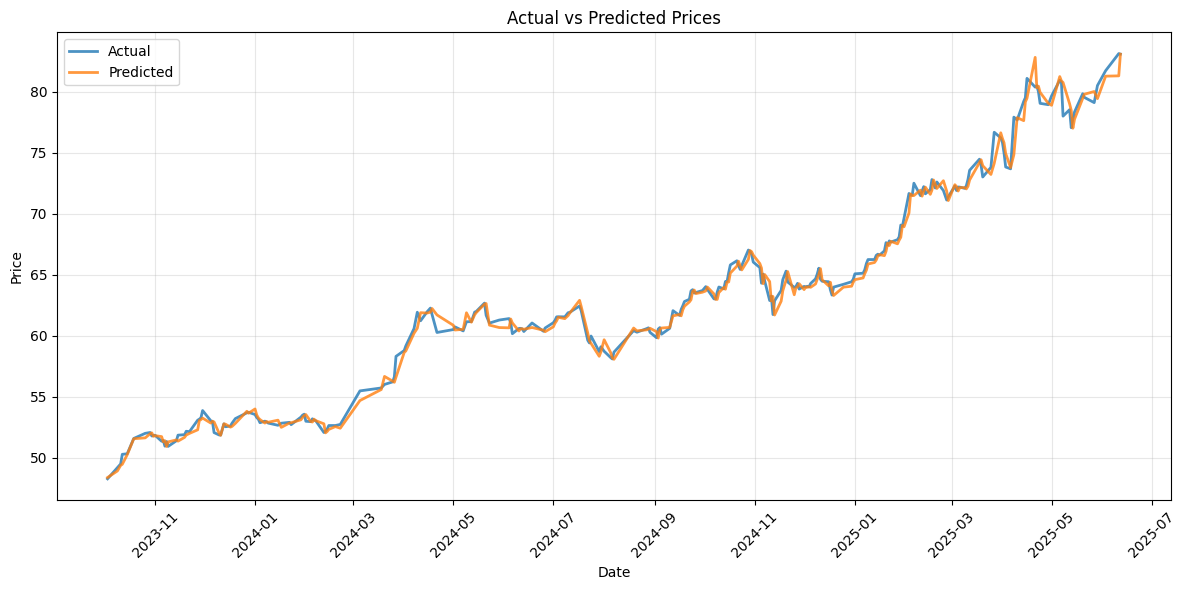

Accuracy Metrics:
MAE: 0.46
RMSE: 0.63
R²: 0.993
MAPE: 0.70%


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming your DataFrame is called 'df'
# df = pd.read_csv('your_file.csv')  # Load your data

# Convert Date column to datetime if needed
df['Date'] = pd.to_datetime(df['Date'])

# Create comparative plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Actual Price'], label='Actual', linewidth=2, alpha=0.8)
plt.plot(df['Date'], df['Predicted Price'], label='Predicted', linewidth=2, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate accuracy metrics
mae = mean_absolute_error(df['Actual Price'], df['Predicted Price'])
rmse = np.sqrt(mean_squared_error(df['Actual Price'], df['Predicted Price']))
r2 = r2_score(df['Actual Price'], df['Predicted Price'])
mape = np.mean(np.abs((df['Actual Price'] - df['Predicted Price']) / df['Actual Price'])) * 100

print(f"Accuracy Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
#Precision and Recall
df = final_df_clean[['Date','next_day_price','predicted_price','Predictions','price_percentage_change', 'Label']]
df['true'] = df['price_percentage_change'].apply(lambda x : 1 if x>0 else 0 )
df['pred'] = df['Predictions'].apply(lambda x : 1 if x>0 else 0 )
df

In [ ]:

def classification_metrics(y_true, y_pred):
    """
    Calculate precision, recall, and F1 score for binary classification.
    y_true: pandas Series or array-like of ground truth (0/1)
    y_pred: pandas Series or array-like of predictions (0/1)
    Returns: dict with precision, recall, f1
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {"precision": precision, "recall": recall, "f1": f1}

# Example usage:
metrics = classification_metrics(df['true'], df['pred'])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1"])


